# Pre Procesamiento - Wine Quality

## 1️⃣ Importación de Librerías

In [32]:
import sys
import os
import warnings

# Obtener la ruta absoluta del directorio raíz del proyecto
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Agregar la carpeta scripts al path
sys.path.append(os.path.join(project_root, "scripts"))

# Importar la función
from load_data import load_wine_data # type: ignore
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
warnings.filterwarnings("ignore")

## 2️⃣ Carga de Datos

In [33]:
# Llamar a la función y obtener los tres DataFrames
df_wine, df_red, df_white = load_wine_data()

df_wine 

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,white
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,white
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,white
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,white


## 3️⃣ Normalizacion de datos

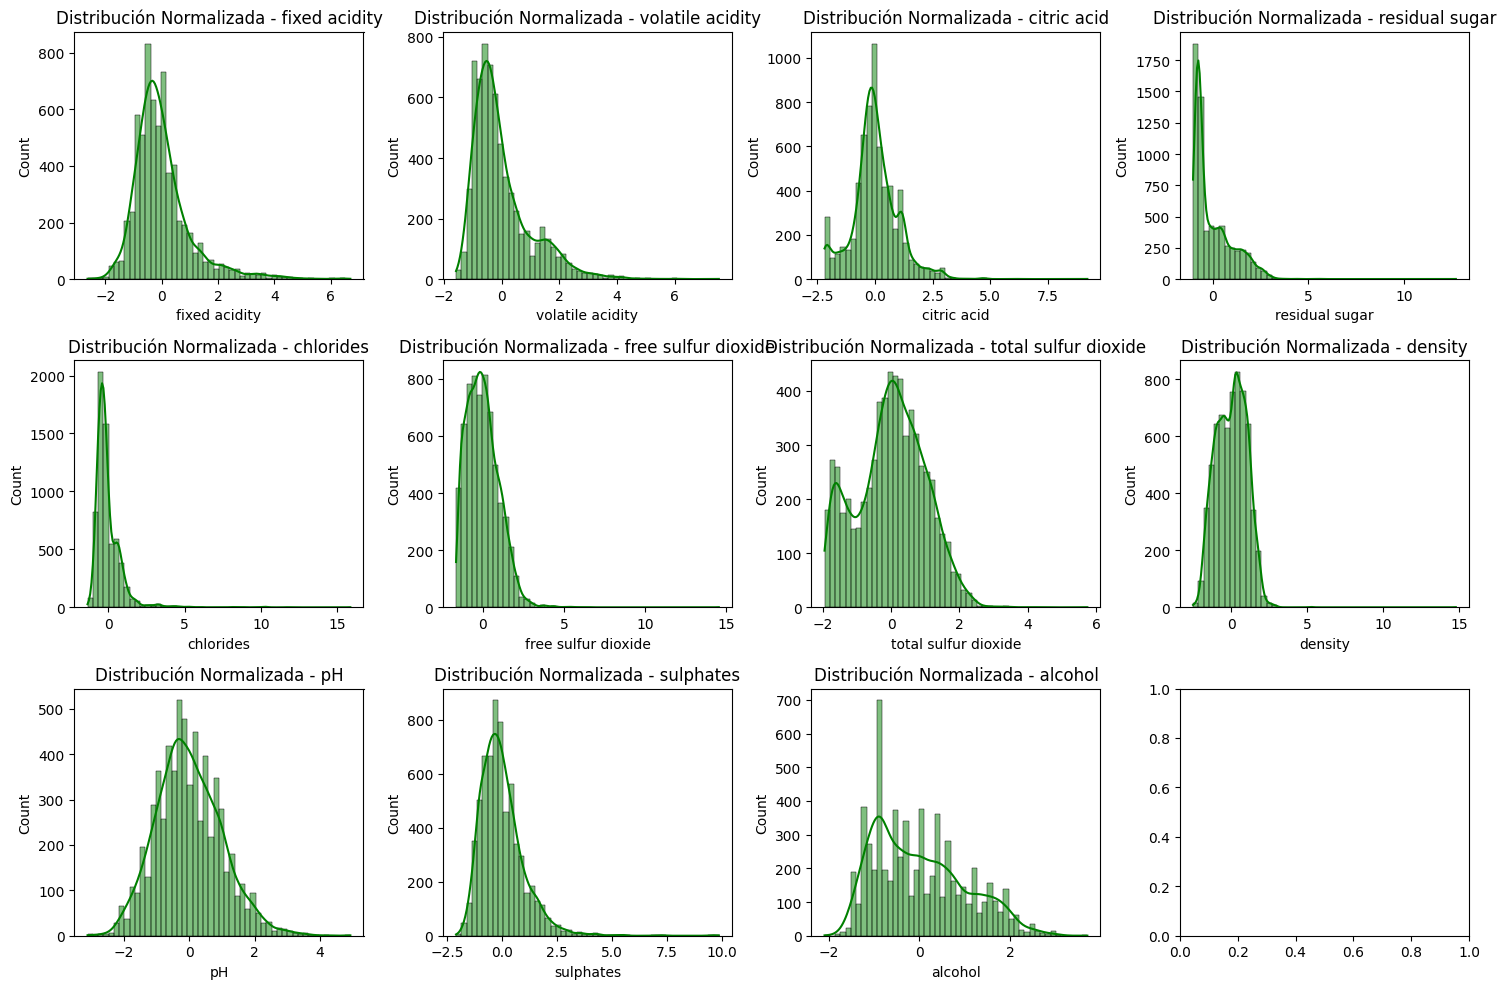

In [34]:
# Seleccionar solo las características numéricas, exceptuando 'quality' y 'wine_type'
numerical_features = df_wine.select_dtypes(include=['float64', 'int64']).columns.drop(['quality'])

# Aplicar StandardScaler
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_wine[numerical_features]), columns=numerical_features)

# Visualizar histogramas después de la normalización
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(numerical_features):
    sns.histplot(df_scaled[col], bins=50, kde=True, ax=axes[i], color="green")
    axes[i].set_title(f"Distribución Normalizada - {col}")

plt.tight_layout()
plt.show()

## 4️⃣ Creación de Nuevas Características

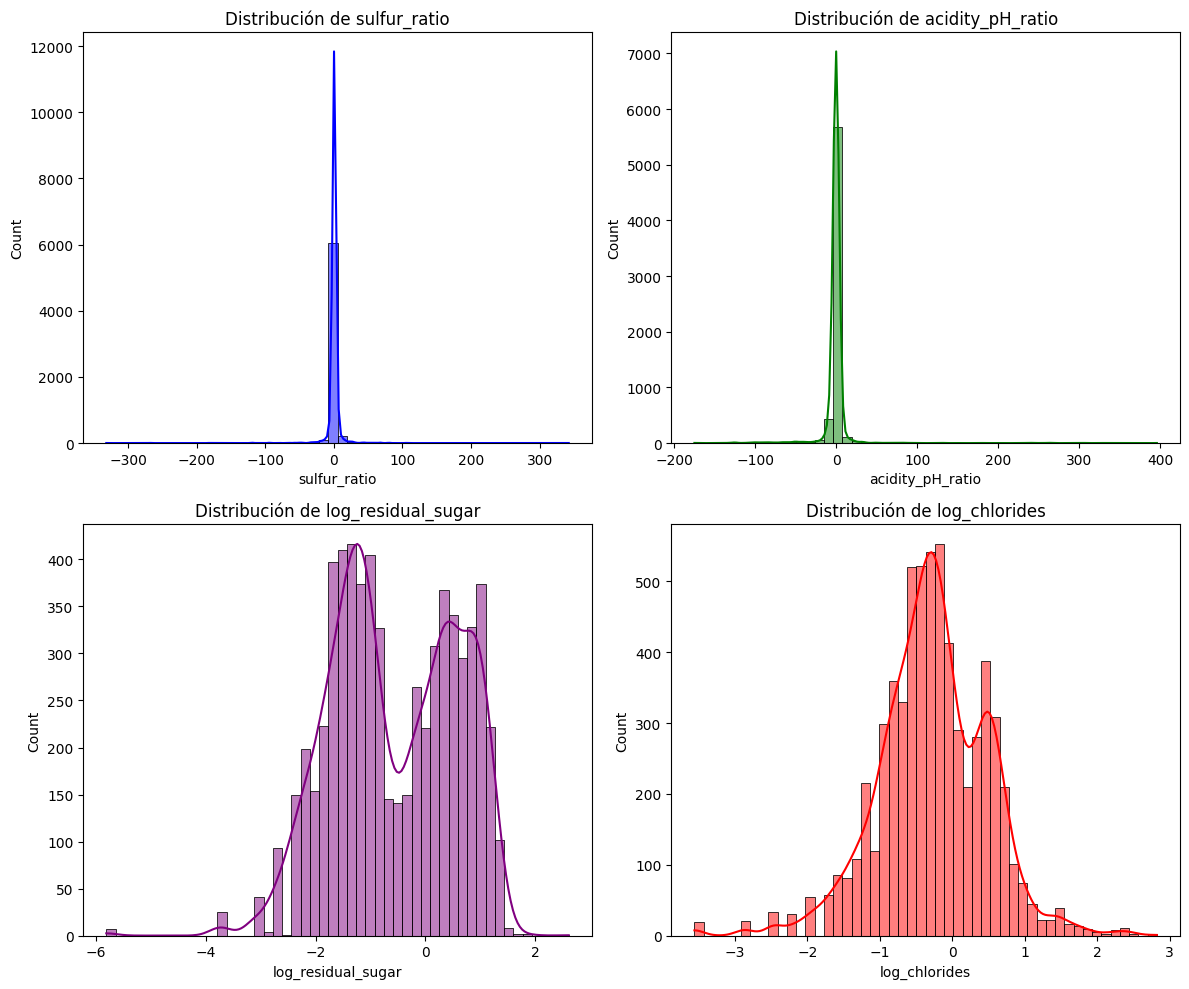

In [35]:
# Recuperar 'quality' y 'wine_type' desde df_wine
df_scaled["quality"] = df_wine["quality"].values

# 1️⃣ Proporción de dióxido de azufre
df_scaled["sulfur_ratio"] = df_scaled["free sulfur dioxide"] / df_scaled["total sulfur dioxide"]

# 2️⃣ Interacción entre acidez y pH
df_scaled["acidity_pH_ratio"] = df_scaled["fixed acidity"] / df_scaled["pH"]

# 3️⃣ Transformaciones logarítmicas (para variables sesgadas)
df_scaled["log_residual_sugar"] = np.log1p(df_scaled["residual sugar"])
df_scaled["log_chlorides"] = np.log1p(df_scaled["chlorides"])

# Visualizar distribuciones de las nuevas características
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.histplot(df_scaled["sulfur_ratio"], bins=50, kde=True, ax=axes[0, 0], color="blue")
axes[0, 0].set_title("Distribución de sulfur_ratio")

sns.histplot(df_scaled["acidity_pH_ratio"], bins=50, kde=True, ax=axes[0, 1], color="green")
axes[0, 1].set_title("Distribución de acidity_pH_ratio")

sns.histplot(df_scaled["log_residual_sugar"], bins=50, kde=True, ax=axes[1, 0], color="purple")
axes[1, 0].set_title("Distribución de log_residual_sugar")

sns.histplot(df_scaled["log_chlorides"], bins=50, kde=True, ax=axes[1, 1], color="red")
axes[1, 1].set_title("Distribución de log_chlorides")

plt.tight_layout()
plt.show()

## 5️⃣ Evaluación de Nuevas Características - Correlación y Mutual Information

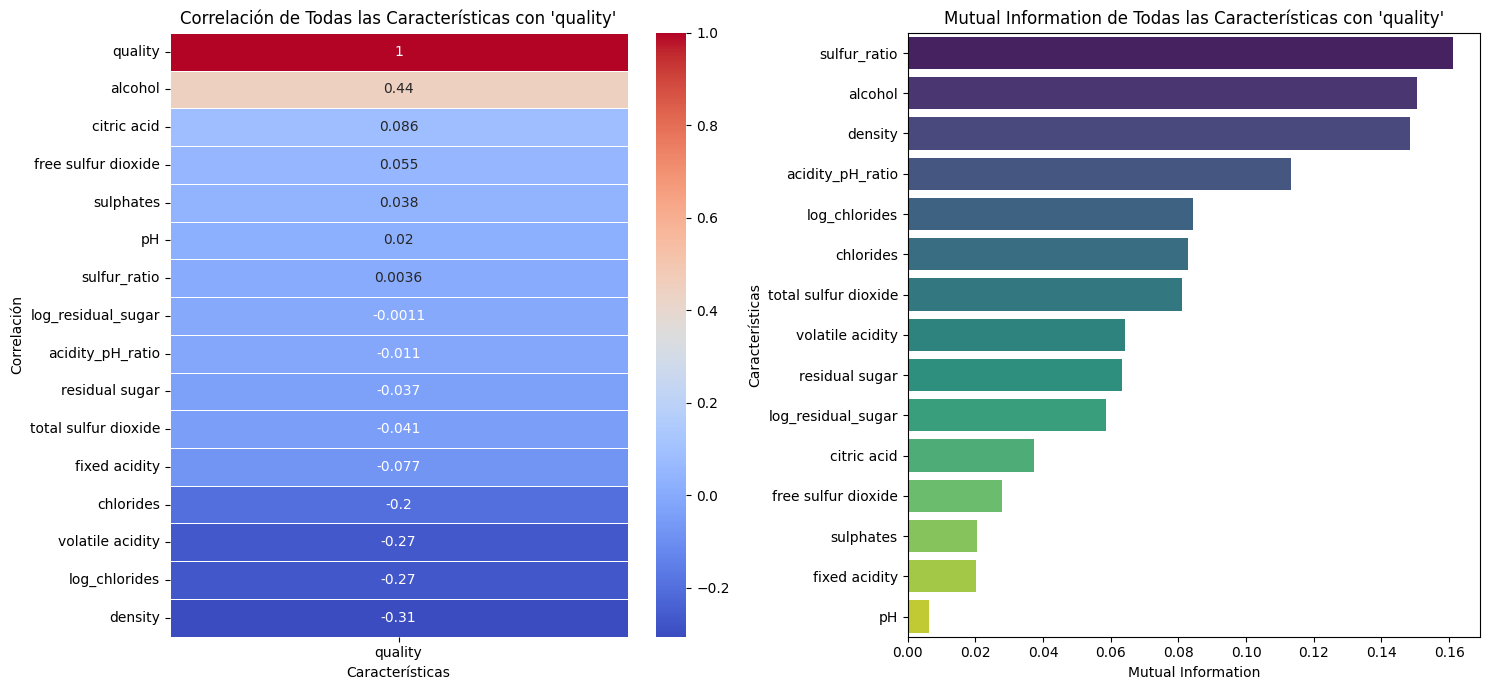

In [36]:
# 1️⃣ Calcular la correlación de las nuevas características con 'quality'
new_features = ["sulfur_ratio", "acidity_pH_ratio", "log_residual_sugar", "log_chlorides"]
# Calcular la correlación de todas las características con 'quality'
correlation_all_features = df_scaled.corr()["quality"].sort_values(ascending=False)

# Calcular la información mutua entre todas las características y 'quality'
X_all = df_scaled.drop(columns=["quality"]).fillna(df_scaled.mean())  # Variables predictoras con NaN llenados
y = df_scaled["quality"]  # Variable objetivo

mutual_info_all = mutual_info_regression(X_all, y, random_state=42)
mutual_info_series_all = pd.Series(mutual_info_all, index=X_all.columns).sort_values(ascending=False)

# Visualizar correlación y mutual information
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Heatmap de correlación con 'quality'
sns.heatmap(correlation_all_features.to_frame(), annot=True, cmap="coolwarm", linewidths=0.5, ax=axes[0])
axes[0].set_title("Correlación de Todas las Características con 'quality'")
axes[0].set_xlabel("Características")
axes[0].set_ylabel("Correlación")

# Gráfico de Mutual Information
sns.barplot(x=mutual_info_series_all, y=mutual_info_series_all.index, palette="viridis", ax=axes[1])
axes[1].set_title("Mutual Information de Todas las Características con 'quality'")
axes[1].set_xlabel("Mutual Information")
axes[1].set_ylabel("Características")

plt.tight_layout()
plt.show()

In [37]:
# Categoriza la calidad del vino en 3 clases basadas en el rango de calidad y usa la etiqueta como variable objetivo
df_scaled["quality_label"] = pd.cut(df_scaled["quality"], bins=[0, 4, 7, 10], labels=["low", "medium", "high"])


In [38]:
df_scaled["quality_label"].value_counts()

quality_label
medium    6053
low        246
high       198
Name: count, dtype: int64

## 6️⃣ División del Dataset en Train/Test

In [39]:
# Definir variables predictoras (X) y objetivo (y)
X = df_scaled.drop(columns=["quality","quality_label"]) 
y = df_scaled["quality_label"]  # Variable objetivo

# División en 80% Train y 20% Test, con estratificación en 'quality' si está desbalanceada
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Mostrar el tamaño de cada conjunto
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")

Tamaño del conjunto de entrenamiento: (4547, 15)
Tamaño del conjunto de prueba: (1950, 15)


## 7️⃣ Guardado de Datos Preprocesados

In [40]:
# Crear carpeta 'processed' si no existe
processed_path = "../data/processed/"
os.makedirs(processed_path, exist_ok=True)

# Guardar los datasets preprocesados
X_train.to_csv(os.path.join(processed_path, "X_train.csv"), index=False)
X_test.to_csv(os.path.join(processed_path, "X_test.csv"), index=False)
y_train.to_csv(os.path.join(processed_path, "y_train.csv"), index=False)
y_test.to_csv(os.path.join(processed_path, "y_test.csv"), index=False)

print("✅ Datos preprocesados guardados en 'data/processed/'")

✅ Datos preprocesados guardados en 'data/processed/'
